# Summarize and aggregate susceptibility scores across all queries

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
from typing import Dict, List, Set, Union, Tuple
import yaml
from ast import literal_eval

import json
import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import font_manager as fm, pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.52653614.kevidu/ipykernel_56778/3431679233.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pand

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from utils import construct_paths_and_dataset_kwargs

'Bitstream Vera Sans'

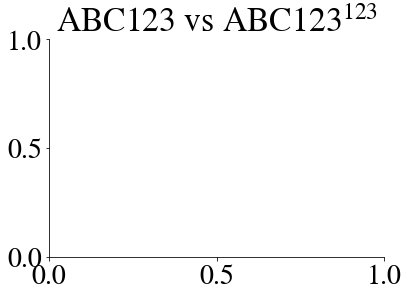

In [11]:
from analysis.mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

In [12]:
##################
### Parameters ###
##################

# Data parameters
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

### Construct dataframes for analysis

In [13]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [14]:
query_ids = list(yago_qec.keys())

In [15]:
analysis_dir = "analysis/summarize/"
os.makedirs(analysis_dir, exist_ok=True)

In [16]:
dataset_names_and_rdps = [("YagoECQ", RAW_DATA_PATH)]
seeds = [8, 9, 10]
model_id_and_quantize_tuples = [("EleutherAI/pythia-6.9b-deduped", True)]
max_contexts = [500]
max_entities = [100]
query_ids = list(yago_qec.keys())
# query_ids = ["http://schema.org/founder"]

ent_selection_fns = [
    "top_entity_uri_degree",
    "top_entity_namesake_degree",
    "random_sample",
]

entity_types = json.dumps(
    ["entities", "gpt_fake_entities"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
query_types = json.dumps(
    ["closed", "open"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
context_types = json.dumps(["base"], separators=(",", ":"))

answer_map = dict()
# answer_map = {0: [" No", " no", " NO", "No", "no", "NO"], 1: [" Yes", " yes", " YES", "Yes", "yes", "YES"]}

cap_per_type = False
ablate = False
deduplicate_entities = True
uniform_contexts = True
overwrite = False


def convert_answer_map_to_tokens(
    model_id: str, answer_map: Dict[int, List[str]]
) -> str:
    answer_map_token_ids = dict()
    if answer_map:
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            padding_side="left",
        )

        for k, v in answer_map.items():
            list_of_token_ids: List[List[str]] = tokenizer(v)["input_ids"]
            valid_token_ids = []
            for token_id in list_of_token_ids:
                if len(token_id) == 1:
                    valid_token_ids.append(token_id[0])
                else:
                    print(
                        f"tokenizer tokenized an answer map token into multiple tokens ({token_id}), which is invalid input."
                    )
            answer_map_token_ids[k] = valid_token_ids
        #     answer_map_token_ids = {
        #         k: [x[0] for x in tokenizer(v)["input_ids"] if len(x) == 1],
        #         for k, v in answer_map.items()
        #     }
    res = json.dumps(answer_map_token_ids, separators=(",", ":"))
    print(res)
    return res


df_dict = []
for ds, rdp in dataset_names_and_rdps:
    for seed in seeds:
        for model_id, do_quantize in model_id_and_quantize_tuples:
            answer_map_in_tokens = convert_answer_map_to_tokens(model_id, answer_map)
            for qid in query_ids:
                for mc in max_contexts:
                    for me in max_entities:
                        for es in ent_selection_fns:
                            dict_vals = dict(
                                DATASET_NAME=ds,
                                RAW_DATA_PATH=rdp,
                                SEED=seed,
                                MODEL_ID=model_id,
                                LOAD_IN_8BIT=do_quantize,
                                QUERY_ID=qid,
                                MAX_CONTEXTS=mc,
                                MAX_ENTITIES=me,
                                CAP_PER_TYPE=cap_per_type,
                                ABLATE_OUT_RELEVANT_CONTEXTS=ablate,
                                DEDUPLICATE_ENTITIES=deduplicate_entities,
                                UNIFORM_CONTEXTS=uniform_contexts,
                                ENTITY_SELECTION_FUNC_NAME=es,
                                OVERWRITE=False,
                                ENTITY_TYPES=json.loads(entity_types),
                                QUERY_TYPES=json.loads(query_types),
                                CONTEXT_TYPES=json.loads(context_types),
                                ANSWER_MAP=json.loads(answer_map_in_tokens)
                                if json.loads(answer_map_in_tokens)
                                else None,
                            )
                            (
                                data_dir,
                                input_dir,
                                entities_path,
                                contexts_path,
                                queries_path,
                                answers_path,
                                val_data_path,
                                model_dir,
                                results_dir,
                                val_results_path,
                                mr_results_path,
                                data_id,
                                _,
                                DATASET_KWARGS_IDENTIFIABLE,
                            ) = construct_paths_and_dataset_kwargs(**dict_vals)
                            if os.path.isfile(val_results_path):
                                res = pd.read_csv(
                                    val_results_path,
                                    index_col=0,
                                    converters={
                                        # "contexts": literal_eval,
                                        "entity": literal_eval,
                                    },
                                )
                                closed_qfs = yago_qec[qid]["query_forms"]["closed"]
                                open_qfs = yago_qec[qid]["query_forms"]["open"]

                                res.loc[
                                    res["query_form"].isin(closed_qfs), "query_type"
                                ] = "closed"
                                res.loc[
                                    res["query_form"].isin(open_qfs), "query_type"
                                ] = "open"
                                res.loc[
                                    res["entity"].isin(
                                        [
                                            (x,)
                                            for x in yago_qec[qid]["gpt_fake_entities"]
                                        ]
                                    ),
                                    "entity_type",
                                ] = "gpt_fake_entities"
                                res.loc[
                                    res["entity"].isin(
                                        [(x,) for x in yago_qec[qid]["entities"]]
                                    ),
                                    "entity_type",
                                ] = "entities"
                                res["entity_classes"] = res["q_id"].apply(
                                    lambda x: yago_qec[qid]["entity_types"]
                                )
                                res["entity"] = res["entity"].apply(lambda x: x[0])
                                scores: List[dict] = res[
                                    [
                                        "entity",
                                        "answer",
                                        "query_form",
                                        "entity_type",
                                        "query_type",
                                        "entity_classes",
                                        "susceptibility_score",
                                        "contexts",
                                        "persuasion_scores_kl",
                                    ]
                                ].to_dict("records")
                                df_dict += [{**dict_vals, **d} for d in scores]

{}
{}
{}


In [17]:
scores_df = pd.DataFrame(df_dict)
scores_df.drop(columns=["contexts", "persuasion_scores_kl"]).to_csv(
    os.path.join(analysis_dir, "summarized_scores.csv"), index=False
)
scores_df["ENTITY_TYPES"] = scores_df["ENTITY_TYPES"].apply(lambda x: tuple(x))
scores_df["QUERY_TYPES"] = scores_df["QUERY_TYPES"].apply(lambda x: tuple(x))
scores_df["CONTEXT_TYPES"] = scores_df["CONTEXT_TYPES"].apply(lambda x: tuple(x))
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146400 entries, 0 to 146399
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATASET_NAME                  146400 non-null  object 
 1   RAW_DATA_PATH                 146400 non-null  object 
 2   SEED                          146400 non-null  int64  
 3   MODEL_ID                      146400 non-null  object 
 4   LOAD_IN_8BIT                  146400 non-null  bool   
 5   QUERY_ID                      146400 non-null  object 
 6   MAX_CONTEXTS                  146400 non-null  int64  
 7   MAX_ENTITIES                  146400 non-null  int64  
 8   CAP_PER_TYPE                  146400 non-null  bool   
 9   ABLATE_OUT_RELEVANT_CONTEXTS  146400 non-null  bool   
 10  DEDUPLICATE_ENTITIES          146400 non-null  bool   
 11  UNIFORM_CONTEXTS              146400 non-null  bool   
 12  ENTITY_SELECTION_FUNC_NAME    146400 non-nul

In [18]:
# Get scores df for vesteinn to analyze the diff in sus score against the entity frequency
scores_df_vesteinn = scores_df[(scores_df["SEED"] == 1)][
    ["QUERY_ID", "query_form", "entity_type", "query_type", "susceptibility_score"]
]
scores_df_vesteinn.to_csv(
    os.path.join(analysis_dir, "sus_scores_real_and_fake_ents.csv")
)

## Variance of susceptibility scores

### Across seeds only

In [19]:
(
    scores_df.groupby(["QUERY_ID", "entity", "query_type", "query_form"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)
# Higher variance for open questions because the "A is ..." tends to differ from the "What's the {} of entity?"

,QUERY_ID,entity,query_type,query_form,sus_score_var,sus_score_mean
0,http://schema.org/about,A Christmas Carol,closed,Q: Does {answer} pertain to '{entity}'?\nA:,2.843630e-07,0.031046
1,http://schema.org/about,A Christmas Carol,closed,Q: Is '{entity}' about {answer}?\nA:,3.090659e-07,0.026277
2,http://schema.org/about,A Christmas Carol,open,'{entity}' is about,4.476646e-04,0.889798
3,http://schema.org/about,A Christmas Carol,open,Q: What is '{entity}' about?\nA:,3.616166e-06,0.215421
4,http://schema.org/about,A Very Long Engagement,closed,Q: Does {answer} pertain to '{entity}'?\nA:,3.651507e-07,0.039896
...,...,...,...,...,...,...
28975,reverse-http://yago-knowledge.org/resource/ter...,"Washington, D.C.",open,{entity} is the terminus of,1.076617e-03,1.012026
28976,reverse-http://yago-knowledge.org/resource/ter...,West Virginia,closed,Q: Is the terminus of {answer} {entity}?\nA:,4.449714e-06,0.026192
28977,reverse-http://yago-knowledge.org/resource/ter...,West Virginia,closed,Q: Is {entity} the terminus of {answer}?\nA:,1.589619e-06,0.019172
28978,reverse-http://yago-knowledge.org/resource/ter...,West Virginia,open,Q: What is {entity} the terminus of?\nA:,5.368924e-05,0.333511


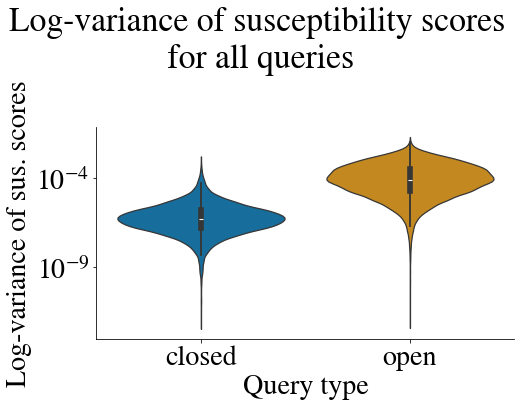

In [20]:
sus_score_var_df = (
    scores_df.groupby(["QUERY_ID", "entity", "query_type", "query_form"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)
sus_score_var_df["log_sus_score_var"] = sus_score_var_df["sus_score_var"].apply(np.log)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    sus_score_var_df,
    y="sus_score_var",
    x="query_type",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
    ax=ax,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of sus. scores")
# ax.set_ylim((-35, -2))
fig.suptitle("Log-variance of susceptibility scores\n for all queries")
plt.tight_layout()

plot_name = f"plot_susscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

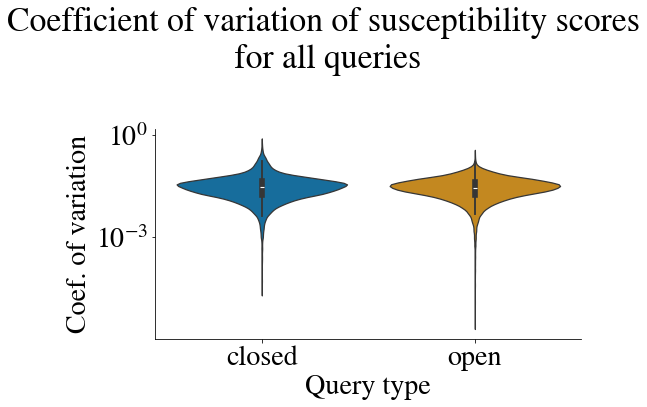

In [21]:
sus_score_var_df["cv"] = (
    sus_score_var_df["sus_score_var"].apply(np.sqrt)
    / sus_score_var_df["sus_score_mean"]
)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    sus_score_var_df,
    y="cv",
    x="query_type",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
    ax=ax,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Coef. of variation")
# ax.set_ylim((-35, -2))
fig.suptitle("Coefficient of variation of susceptibility scores\n for all queries")
plt.tight_layout()

plot_name = f"plot_susscore_cv_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Across seeds and query forms

In [22]:
(
    scores_df.groupby(["QUERY_ID", "entity", "query_type", "SEED"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)

,QUERY_ID,entity,query_type,SEED,sus_score_var,sus_score_mean
0,http://schema.org/about,A Christmas Carol,closed,8,0.000009,0.029051
1,http://schema.org/about,A Christmas Carol,closed,9,0.000015,0.028714
2,http://schema.org/about,A Christmas Carol,closed,10,0.000010,0.028219
3,http://schema.org/about,A Christmas Carol,open,8,0.213092,0.539644
4,http://schema.org/about,A Christmas Carol,open,9,0.238241,0.561525
...,...,...,...,...,...,...
73193,reverse-http://yago-knowledge.org/resource/ter...,Zenith Peak,open,10,0.940497,1.236361
73194,reverse-http://yago-knowledge.org/resource/ter...,Zephyr Ziggurat,closed,8,0.000027,0.018030
73195,reverse-http://yago-knowledge.org/resource/ter...,Zephyr Ziggurat,open,8,1.261346,1.157193
73196,reverse-http://yago-knowledge.org/resource/ter...,Zephyr’s Zenith,closed,10,0.000527,0.033494


2.777615356625038


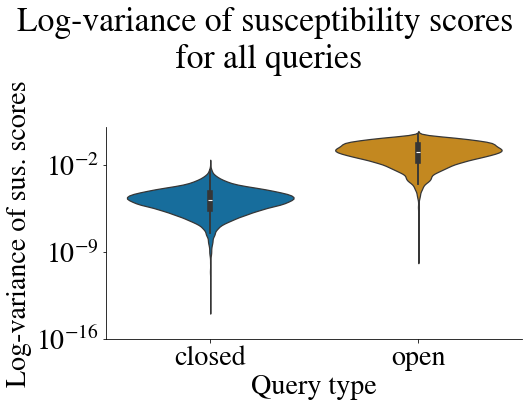

In [23]:
sus_score_var_seed_and_qf_df = (
    scores_df.groupby(["QUERY_ID", "entity", "query_type"])
    .agg(
        sus_score_var=("susceptibility_score", "var"),
        sus_score_mean=("susceptibility_score", "mean"),
    )
    .dropna()
    .reset_index()
)
sus_score_var_seed_and_qf_df["log_sus_score_var"] = sus_score_var_seed_and_qf_df[
    "sus_score_var"
].apply(np.log)
sus_score_var_seed_and_qf_df["cv"] = (
    sus_score_var_seed_and_qf_df["sus_score_var"].apply(np.sqrt)
    / sus_score_var_seed_and_qf_df["sus_score_mean"]
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    sus_score_var_seed_and_qf_df,
    y="sus_score_var",
    x="query_type",
    hue="query_type",
    order=sorted(sus_score_var_seed_and_qf_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_seed_and_qf_df["query_type"].unique()),
    ax=ax,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of sus. scores")
ax.set_ylim((10**-16, 10**1))

# tcks = ax.get_yticks()
max_y_tick = max(sus_score_var_seed_and_qf_df["sus_score_var"])
# max_y_tick = 10 ** np.ceil(np.log10(max_y_tick))
# tcks[-1] = max_y_tick
# ax.set_yticks(tcks)
print(max_y_tick)

fig.suptitle("Log-variance of susceptibility scores\n for all queries")
plt.tight_layout()

plot_name = (
    f"plot_susscore_variance_across_all_queries_seed_and_queryforms_closed_vs_open"
)
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

## Variance of persuasion scores

### Preprocessing


In [24]:
# Reliability/variance of persuasion scores
scores_df["contexts"] = scores_df["contexts"].apply(literal_eval)

In [25]:
from tqdm import tqdm

tqdm.pandas()
scores_df["persuasion_scores_kl"] = scores_df["persuasion_scores_kl"].progress_apply(
    literal_eval
)

100%|██████████| 146400/146400 [06:59<00:00, 349.06it/s]


In [26]:
scores_df.columns

Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
       'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
       'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
       'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
       'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
       'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
       'susceptibility_score', 'contexts', 'persuasion_scores_kl'],
      dtype='object')

In [27]:
scores_df.head()

,DATASET_NAME,RAW_DATA_PATH,SEED,MODEL_ID,LOAD_IN_8BIT,QUERY_ID,MAX_CONTEXTS,MAX_ENTITIES,CAP_PER_TYPE,ABLATE_OUT_RELEVANT_CONTEXTS,...,ANSWER_MAP,entity,answer,query_form,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores_kl
0,YagoECQ,data/YagoECQ/yago_qec.json,8,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/about,500,100,False,False,...,None,Crime and Punishment,anguish,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.043855,['A Christmas Carol' is about psychoanalysis.\...,"[0.027815370652517164, 0.043836283026991815, 0..."
1,YagoECQ,data/YagoECQ/yago_qec.json,8,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/about,500,100,False,False,...,None,Stranger Things,monster,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.038873,['A Christmas Carol' is about psychoanalysis.\...,"[0.022833921013827058, 0.04258298997236172, 0...."
2,YagoECQ,data/YagoECQ/yago_qec.json,8,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/about,500,100,False,False,...,None,Sleeping Beauty,prostitution,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.030013,['A Christmas Carol' is about psychoanalysis.\...,"[0.015203277054757696, 0.03643121713720158, 0...."
3,YagoECQ,data/YagoECQ/yago_qec.json,8,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/about,500,100,False,False,...,None,Indiana Jones and the Kingdom of the Crystal S...,Cold War,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.033426,['A Christmas Carol' is about psychoanalysis.\...,"[0.02278468065604346, 0.02966140934779633, 0.0..."
4,YagoECQ,data/YagoECQ/yago_qec.json,8,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/about,500,100,False,False,...,None,A Christmas Carol,time travel,Q: Is '{entity}' about {answer}?\nA:,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.026918,['A Christmas Carol' is about psychoanalysis.\...,"[0.028009139192619322, 0.06099025143506954, 0...."


In [28]:
from functools import reduce

# Define a custom aggregation function for intersection
def intersection_aggregate(x):
    # Take the intersection of all sets in the group
    return reduce(lambda a, b: set(a).intersection(set(b)), x)

In [29]:
# Function to filter rows
def filter_rows_by_unique_values(dataframe, column_name, unique_count):
    # Group by the specified column and filter
    filtered_df = dataframe.groupby(column_name).filter(
        lambda x: x["SEED"].nunique() == unique_count
    )
    return filtered_df


# Applying the function
filtered_df = filter_rows_by_unique_values(
    scores_df, ["QUERY_ID", "entity", "query_form", "query_type"], 3
)
filtered_df["contexts"] = filtered_df["contexts"].progress_apply(tuple)
filtered_df["persuasion_scores_kl"] = filtered_df[
    "persuasion_scores_kl"
].progress_apply(tuple)
filtered_df["entity_classes"] = filtered_df["entity_classes"].progress_apply(tuple)
filtered_df = filtered_df.drop_duplicates()

100%|██████████| 73960/73960 [00:00<00:00, 558285.40it/s]


In [30]:
set(
    filtered_df[["QUERY_ID", "entity", "query_form", "query_type"]].value_counts()
)  # this should be just 3

{3}

In [31]:
overlapping_contexts_df = (
    filtered_df.groupby(["QUERY_ID", "entity"]).agg(
        shared_contexts=("contexts", intersection_aggregate)
    )
    # .to_frame()
    .reset_index()
)
overlapping_contexts_df = overlapping_contexts_df[
    overlapping_contexts_df["shared_contexts"] != set()
]
overlapping_contexts_df["shared_contexts"] = overlapping_contexts_df[
    "shared_contexts"
].progress_apply(tuple)
overlapping_contexts_df

100%|██████████| 1639/1639 [00:00<00:00, 243593.93it/s]


,QUERY_ID,entity,shared_contexts
0,http://schema.org/about,A Christmas Carol,('A Very Long Engagement' is about World War I...
1,http://schema.org/about,A Very Long Engagement,('A Very Long Engagement' is about World War I...
2,http://schema.org/about,Abrasion,('A Very Long Engagement' is about World War I...
3,http://schema.org/about,Air Force One,('A Very Long Engagement' is about World War I...
4,http://schema.org/about,Anna and the King,('A Very Long Engagement' is about World War I...
...,...,...,...
6108,reverse-http://yago-knowledge.org/resource/stu...,Pyotr Ilyich Tchaikovsky,(A student of Nikolai Rimsky-Korsakov was Loui...
6109,reverse-http://yago-knowledge.org/resource/stu...,Raymond Aron,(A student of Nikolai Rimsky-Korsakov was Loui...
6110,reverse-http://yago-knowledge.org/resource/stu...,Robert Bunsen,(A student of Nikolai Rimsky-Korsakov was Loui...
6111,reverse-http://yago-knowledge.org/resource/stu...,William of Ockham,(A student of Nikolai Rimsky-Korsakov was Loui...


In [32]:
overlapping_contexts_filtered_df = overlapping_contexts_df.merge(
    filtered_df, on=["QUERY_ID", "entity"], how="inner"
)
overlapping_contexts_filtered_df = overlapping_contexts_filtered_df.loc[
    :, overlapping_contexts_filtered_df.nunique() > 1
]

In [33]:
exploded_overlapping_contexts_filtered_df = overlapping_contexts_filtered_df.explode(
    "shared_contexts"
)
set(
    exploded_overlapping_contexts_filtered_df[
        ["QUERY_ID", "entity", "shared_contexts", "query_form"]
    ].value_counts()
)  # should just be {3} still

{3}

In [34]:
exploded_overlapping_contexts_filtered_df

,QUERY_ID,entity,shared_contexts,SEED,answer,query_form,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores_kl
0,http://schema.org/about,A Christmas Carol,'A Very Long Engagement' is about World War II.\n,8,time travel,Q: Is '{entity}' about {answer}?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.026918,('A Christmas Carol' is about psychoanalysis.\...,"(0.028009139192619322, 0.06099025143506954, 0...."
0,http://schema.org/about,A Christmas Carol,'Tron: Legacy' is about World War II.\n,8,time travel,Q: Is '{entity}' about {answer}?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.026918,('A Christmas Carol' is about psychoanalysis.\...,"(0.028009139192619322, 0.06099025143506954, 0...."
1,http://schema.org/about,A Christmas Carol,'A Very Long Engagement' is about World War II.\n,8,time travel,Q: Does {answer} pertain to '{entity}'?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.031184,('A Christmas Carol' is about psychoanalysis.\...,"(0.05892524778278902, 0.08278460086793153, 0.0..."
1,http://schema.org/about,A Christmas Carol,'Tron: Legacy' is about World War II.\n,8,time travel,Q: Does {answer} pertain to '{entity}'?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.031184,('A Christmas Carol' is about psychoanalysis.\...,"(0.05892524778278902, 0.08278460086793153, 0.0..."
2,http://schema.org/about,A Christmas Carol,'A Very Long Engagement' is about World War II.\n,8,time travel,Q: What is '{entity}' about?\nA:,entities,open,"(http://schema.org/CreativeWork, http://schema...",0.213231,('A Christmas Carol' is about psychoanalysis.\...,"(0.44117218428566113, 0.43849332630702015, 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...
19663,reverse-http://yago-knowledge.org/resource/stu...,Émile Durkheim,A student of Nikolai Rimsky-Korsakov was Louis...,9,Maurice Halbwachs,A student of {entity} was,entities,open,"(http://schema.org/Person,)",0.445461,(A student of Abdus Salam was Dzongsar Jamyang...,"(0.3088692440019256, 1.7759141643508187, 0.847..."
19664,reverse-http://yago-knowledge.org/resource/stu...,Émile Durkheim,A student of Nikolai Rimsky-Korsakov was Louis...,10,Winifred Hoernlé,Q: Was {answer} a student of {entity}?\nA:,entities,closed,"(http://schema.org/Person,)",0.042858,(A student of Abdus Salam was Shamil Omarov.\n...,"(0.017759770040055644, 0.031562215664805646, 0..."
19665,reverse-http://yago-knowledge.org/resource/stu...,Émile Durkheim,A student of Nikolai Rimsky-Korsakov was Louis...,10,Winifred Hoernlé,Q: Was a student of {entity} {answer}?\nA:,entities,closed,"(http://schema.org/Person,)",0.055732,(A student of Abdus Salam was Shamil Omarov.\n...,"(0.027589620991856596, 0.06027735879789142, 0...."
19666,reverse-http://yago-knowledge.org/resource/stu...,Émile Durkheim,A student of Nikolai Rimsky-Korsakov was Louis...,10,Winifred Hoernlé,Q: Who was a student of {entity}?\nA:,entities,open,"(http://schema.org/Person,)",0.330770,(A student of Abdus Salam was Shamil Omarov.\n...,"(0.5998631753343964, 0.3583802117985148, 0.168..."


In [35]:
row = exploded_overlapping_contexts_filtered_df.iloc[0]


def get_p_score_for_shared_context(row: pd.Series):
    shared_context_ind = list(row["contexts"]).index(row["shared_contexts"])
    p_score_for_shared_context = row["persuasion_scores_kl"][shared_context_ind]
    return p_score_for_shared_context

In [36]:
exploded_overlapping_contexts_filtered_df[
    "p_score"
] = exploded_overlapping_contexts_filtered_df.progress_apply(
    get_p_score_for_shared_context, axis=1
)

100%|██████████| 318756/318756 [00:11<00:00, 28402.21it/s]


### Across seeds only

In [37]:
var_pscore_df = (
    exploded_overlapping_contexts_filtered_df.groupby(
        ["QUERY_ID", "entity", "query_form", "query_type", "shared_contexts"]
    )
    .agg(var_p_score=("p_score", "var"), mean_p_score=("p_score", "mean"))
    .reset_index()
)
var_pscore_df["log_var_p_score"] = var_pscore_df["var_p_score"].progress_apply(np.log)
var_pscore_df["cv"] = (
    var_pscore_df["var_p_score"].apply(np.sqrt) / var_pscore_df["mean_p_score"]
)

100%|██████████| 106252/106252 [00:00<00:00, 263255.23it/s]


In [38]:
var_pscore_df.sort_values(by=["var_p_score"], ascending=False).head(3)

,QUERY_ID,entity,query_form,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
495,http://schema.org/affiliation,Jyrki Katainen,{entity} is affiliated with,open,Vagit Alekperov is affiliated with 24th U-boat...,0.508804,2.993856,-0.675693,0.238256
519,http://schema.org/affiliation,Mario Draghi,{entity} is affiliated with,open,Vagit Alekperov is affiliated with 24th U-boat...,0.427487,3.141028,-0.849832,0.208156
587,http://schema.org/affiliation,Valgerd Svarstad Haugland,{entity} is affiliated with,open,Vagit Alekperov is affiliated with 24th U-boat...,0.395125,3.544957,-0.928553,0.177319


In [39]:
var_pscore_df.sort_values(by=["cv"], ascending=False)

,QUERY_ID,entity,query_form,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
65990,http://schema.org/officialLanguage,Taiwan,Q: Is {entity}'s official language {answer}?\nA:,closed,The official language of South Africa is Frenc...,5.142134e-04,0.021523,-7.572872,1.053573
65148,http://schema.org/officialLanguage,Philippines,Q: Is {entity}'s official language {answer}?\nA:,closed,The official language of Philippines is Englis...,1.138967e-02,0.106532,-4.475048,1.001784
65985,http://schema.org/officialLanguage,Taiwan,Q: Is {entity}'s official language {answer}?\nA:,closed,The official language of Nigeria is Serbian.\n,1.083720e-03,0.033311,-6.827356,0.988256
65124,http://schema.org/officialLanguage,Philippines,Q: Is {answer} the official language of {entit...,closed,The official language of Bangladesh is English.\n,9.626570e-04,0.033012,-6.945813,0.939855
64234,http://schema.org/officialLanguage,Greece,Q: Is {answer} the official language of {entit...,closed,The official language of Serbia is English.\n,7.099965e-04,0.030778,-7.250250,0.865748
...,...,...,...,...,...,...,...,...,...
69828,http://schema.org/recordLabel,Xmal Deutschland,Q: Is {entity} signed to {answer} as a record ...,closed,Ethereal Edge's record label is MCA Inc..\n,5.188267e-10,0.029462,-21.379451,0.000773
99741,http://yago-knowledge.org/resource/playsIn,Nigel de Jong,Q: Does {entity} play in the '{answer}'?\nA:,closed,The league that Gojko Kačar plays in is the NB...,8.465404e-10,0.037687,-20.889863,0.000772
87299,http://yago-knowledge.org/resource/beliefSystem,Paul Pogba,Q: Does {entity} believe in {answer}?\nA:,closed,The belief system of Edward Drinker Cope is Ca...,1.149800e-09,0.054088,-20.583678,0.000627
34733,http://schema.org/material,Cloud Gate,{entity} is made of,open,The Marriage of the Virgin is made of oil pain...,2.024545e-09,0.090971,-20.017921,0.000495


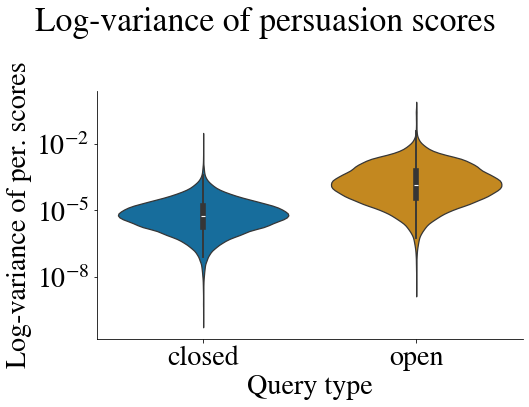

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=var_pscore_df,
    x="query_type",
    y="var_p_score",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of per. scores")
fig.suptitle("Log-variance of persuasion scores")
plt.tight_layout()

plot_name = f"plot_persuasionscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

0.5088037427841715


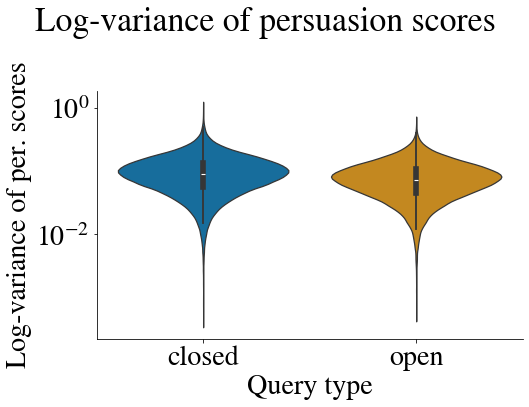

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=var_pscore_df,
    x="query_type",
    y="cv",
    hue="query_type",
    order=sorted(var_pscore_df["query_type"].unique()),
    hue_order=sorted(var_pscore_df["query_type"].unique()),
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of per. scores")
fig.suptitle("Log-variance of persuasion scores")
plt.tight_layout()

plot_name = f"plot_persuasionscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
print(max(var_pscore_df["var_p_score"]))

### Across seeds and query forms

In [42]:
var_pscore_seed_and_qf_df = (
    exploded_overlapping_contexts_filtered_df.groupby(
        ["QUERY_ID", "entity", "query_type", "shared_contexts"]
    )
    .agg(var_p_score=("p_score", "var"), mean_p_score=("p_score", "mean"))
    .reset_index()
)
var_pscore_seed_and_qf_df["log_var_p_score"] = var_pscore_seed_and_qf_df[
    "var_p_score"
].progress_apply(np.log)

var_pscore_seed_and_qf_df["cv"] = (
    var_pscore_seed_and_qf_df["var_p_score"].apply(np.sqrt)
    / var_pscore_seed_and_qf_df["mean_p_score"]
)

var_pscore_seed_and_qf_df

100%|██████████| 53126/53126 [00:00<00:00, 301611.42it/s]


,QUERY_ID,entity,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
0,http://schema.org/about,A Christmas Carol,closed,'A Very Long Engagement' is about World War II.\n,0.000012,0.018298,-11.321815,0.190152
1,http://schema.org/about,A Christmas Carol,closed,'Tron: Legacy' is about World War II.\n,0.000016,0.033062,-11.043472,0.120951
2,http://schema.org/about,A Christmas Carol,open,'A Very Long Engagement' is about World War II.\n,0.036250,0.329157,-3.317318,0.578429
3,http://schema.org/about,A Christmas Carol,open,'Tron: Legacy' is about World War II.\n,0.013893,0.169324,-4.276400,0.696104
4,http://schema.org/about,A Very Long Engagement,closed,'A Very Long Engagement' is about World War II.\n,0.000010,0.051728,-11.466883,0.062556
...,...,...,...,...,...,...,...,...
53121,reverse-http://yago-knowledge.org/resource/stu...,Robert Bunsen,open,A student of Nikolai Rimsky-Korsakov was Louis...,0.004080,0.218259,-5.501571,0.292668
53122,reverse-http://yago-knowledge.org/resource/stu...,William of Ockham,closed,A student of Nikolai Rimsky-Korsakov was Louis...,0.000141,0.034945,-8.870284,0.339199
53123,reverse-http://yago-knowledge.org/resource/stu...,William of Ockham,open,A student of Nikolai Rimsky-Korsakov was Louis...,0.000707,0.152921,-7.253785,0.173938
53124,reverse-http://yago-knowledge.org/resource/stu...,Émile Durkheim,closed,A student of Nikolai Rimsky-Korsakov was Louis...,0.000122,0.050328,-9.010838,0.219538


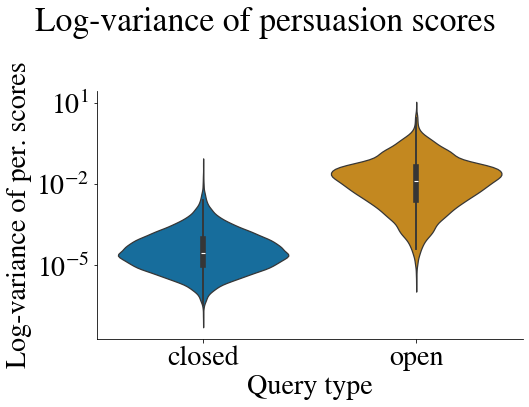

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=var_pscore_seed_and_qf_df,
    x="query_type",
    y="var_p_score",
    hue="query_type",
    order=sorted(var_pscore_seed_and_qf_df["query_type"].unique()),
    hue_order=sorted(var_pscore_seed_and_qf_df["query_type"].unique()),
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of per. scores")
fig.suptitle("Log-variance of persuasion scores")
plt.tight_layout()

plot_name = (
    f"plot_persuasionscore_variance_across_all_queries_seed_and_qf_closed_vs_open"
)
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### One plot

In [44]:
var_pscore_df["var"] = var_pscore_df["var_p_score"]
var_pscore_df["log_var"] = var_pscore_df["log_var_p_score"]
var_pscore_df["score_type"] = "p_score"
var_pscore_df.head(1)

,QUERY_ID,entity,query_form,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv,var,log_var,score_type
0,http://schema.org/about,A Christmas Carol,'{entity}' is about,open,'A Very Long Engagement' is about World War II.\n,0.000337,0.502477,-7.994002,0.03656,0.000337,-7.994002,p_score


In [45]:
sus_score_var_df["var"] = sus_score_var_df["sus_score_var"]
sus_score_var_df["log_var"] = sus_score_var_df["log_sus_score_var"]
sus_score_var_df["score_type"] = "sus_score"
sus_score_var_df.head(1)

,QUERY_ID,entity,query_type,query_form,sus_score_var,sus_score_mean,log_sus_score_var,cv,var,log_var,score_type
0,http://schema.org/about,A Christmas Carol,closed,Q: Does {answer} pertain to '{entity}'?\nA:,2.843630e-07,0.031046,-15.073014,0.017176,2.843630e-07,-15.073014,sus_score


In [46]:
shared_cols = list(set(sus_score_var_df.columns).intersection(var_pscore_df.columns))
combined_df = pd.concat(
    [sus_score_var_df[shared_cols], var_pscore_df[shared_cols]], axis=0
)
combined_df.head(1)

,score_type,log_var,cv,query_type,QUERY_ID,entity,var,query_form
0,sus_score,-15.073014,0.017176,closed,http://schema.org/about,A Christmas Carol,2.843630e-07,Q: Does {answer} pertain to '{entity}'?\nA:


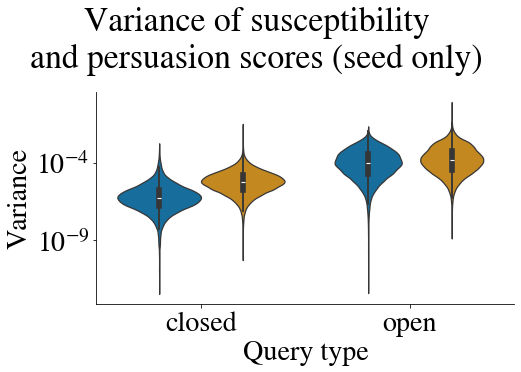

In [47]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_df,
    x="query_type",
    y="var",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Variance")
fig.suptitle("Variance of susceptibility\nand persuasion scores (seed only)", y=0.9)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

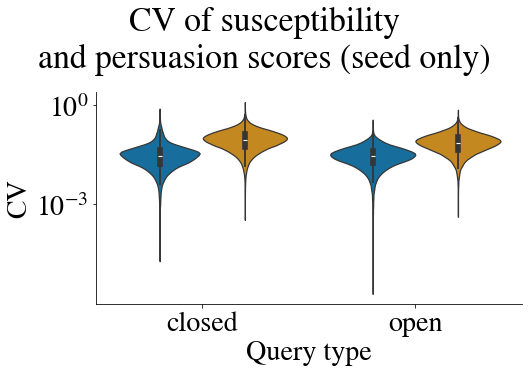

In [48]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_df,
    x="query_type",
    y="cv",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("CV")
fig.suptitle("CV of susceptibility\nand persuasion scores (seed only)", y=0.9)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [49]:
var_pscore_seed_and_qf_df

,QUERY_ID,entity,query_type,shared_contexts,var_p_score,mean_p_score,log_var_p_score,cv
0,http://schema.org/about,A Christmas Carol,closed,'A Very Long Engagement' is about World War II.\n,0.000012,0.018298,-11.321815,0.190152
1,http://schema.org/about,A Christmas Carol,closed,'Tron: Legacy' is about World War II.\n,0.000016,0.033062,-11.043472,0.120951
2,http://schema.org/about,A Christmas Carol,open,'A Very Long Engagement' is about World War II.\n,0.036250,0.329157,-3.317318,0.578429
3,http://schema.org/about,A Christmas Carol,open,'Tron: Legacy' is about World War II.\n,0.013893,0.169324,-4.276400,0.696104
4,http://schema.org/about,A Very Long Engagement,closed,'A Very Long Engagement' is about World War II.\n,0.000010,0.051728,-11.466883,0.062556
...,...,...,...,...,...,...,...,...
53121,reverse-http://yago-knowledge.org/resource/stu...,Robert Bunsen,open,A student of Nikolai Rimsky-Korsakov was Louis...,0.004080,0.218259,-5.501571,0.292668
53122,reverse-http://yago-knowledge.org/resource/stu...,William of Ockham,closed,A student of Nikolai Rimsky-Korsakov was Louis...,0.000141,0.034945,-8.870284,0.339199
53123,reverse-http://yago-knowledge.org/resource/stu...,William of Ockham,open,A student of Nikolai Rimsky-Korsakov was Louis...,0.000707,0.152921,-7.253785,0.173938
53124,reverse-http://yago-knowledge.org/resource/stu...,Émile Durkheim,closed,A student of Nikolai Rimsky-Korsakov was Louis...,0.000122,0.050328,-9.010838,0.219538


In [50]:
var_pscore_seed_and_qf_df["var"] = var_pscore_seed_and_qf_df["var_p_score"]
# var_pscore_seed_and_qf_df["log_var"] = var_pscore_seed_and_qf_df["log_var_p_score"]
var_pscore_seed_and_qf_df["score_type"] = "p_score"
var_pscore_seed_and_qf_df.head(1)

sus_score_var_seed_and_qf_df["var"] = sus_score_var_seed_and_qf_df["sus_score_var"]
# sus_score_var_seed_and_qf_df["log_var"] = sus_score_var_seed_and_qf_df[
#     "log_sus_score_var"
# ]
sus_score_var_seed_and_qf_df["score_type"] = "sus_score"
sus_score_var_seed_and_qf_df.head(1)

shared_cols = list(
    set(sus_score_var_seed_and_qf_df.columns).intersection(
        var_pscore_seed_and_qf_df.columns
    )
)
combined_seed_and_qf_df = pd.concat(
    [sus_score_var_seed_and_qf_df[shared_cols], var_pscore_seed_and_qf_df[shared_cols]],
    axis=0,
)
combined_seed_and_qf_df.head(1)

,score_type,cv,query_type,QUERY_ID,entity,var
0,sus_score,0.09271,closed,http://schema.org/about,A Christmas Carol,0.000007


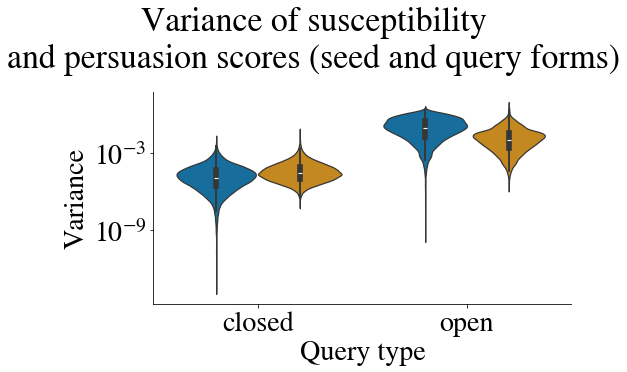

In [51]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_seed_and_qf_df,
    x="query_type",
    y="var",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_seed_and_qf_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Variance")
fig.suptitle(
    "Variance of susceptibility\nand persuasion scores (seed and query forms)", y=0.9
)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

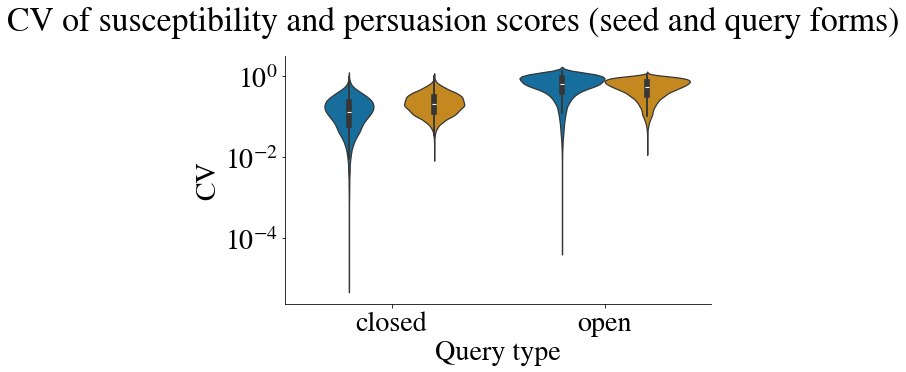

In [52]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_seed_and_qf_df,
    x="query_type",
    y="cv",
    # y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_seed_and_qf_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
    legend=None,
    log_scale=True,
)
ax.set_xlabel("Query type")
ax.set_ylabel("CV")
fig.suptitle("CV of susceptibility and persuasion scores (seed and query forms)", y=0.9)
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

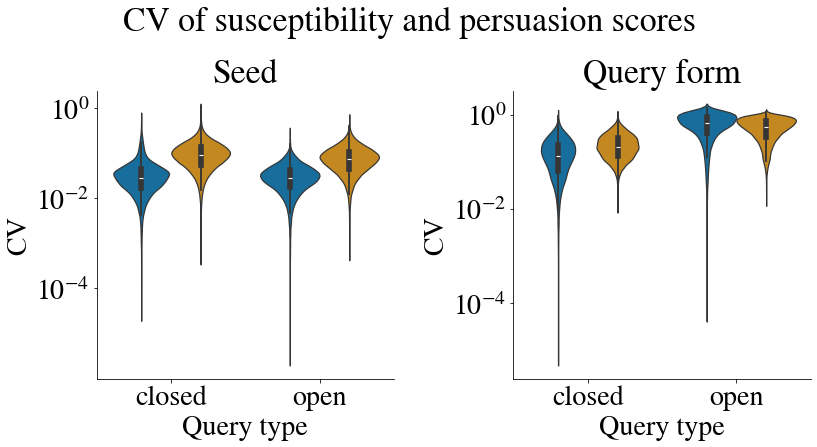

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
var_axes_dict = {"Seed": combined_df, "Query form": combined_seed_and_qf_df}
for i, (name, df) in enumerate(var_axes_dict.items()):
    ax = axes[i]
    sns.violinplot(
        data=df,
        x="query_type",
        y="cv",
        # y="log_var",
        hue="score_type",
        dodge=True,
        order=sorted(combined_seed_and_qf_df["query_type"].unique()),
        hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
        legend=None,
        log_scale=True,
        ax=ax,
    )
    ax.set_xlabel("Query type")
    ax.set_ylabel("CV")
    ax.set_title(name)

fig.suptitle(
    "CV of susceptibility and persuasion scores",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_cv_all_scores_qt_varaxes"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

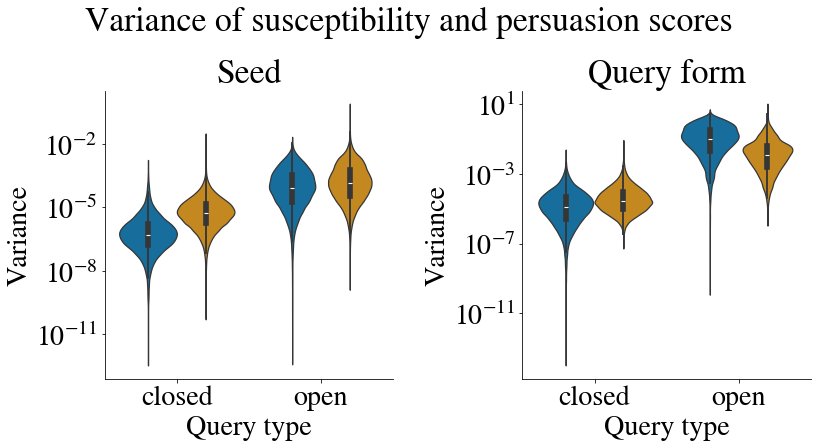

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
var_axes_dict = {"Seed": combined_df, "Query form": combined_seed_and_qf_df}
for i, (name, df) in enumerate(var_axes_dict.items()):
    ax = axes[i]
    sns.violinplot(
        data=df,
        x="query_type",
        y="var",
        # y="log_var",
        hue="score_type",
        dodge=True,
        order=sorted(combined_seed_and_qf_df["query_type"].unique()),
        hue_order=reversed(sorted(combined_seed_and_qf_df["score_type"].unique())),
        legend=None,
        log_scale=True,
        ax=ax,
    )
    ax.set_xlabel("Query type")
    ax.set_ylabel("Variance")
    ax.set_title(name)

fig.suptitle(
    "Variance of susceptibility and persuasion scores",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_var_all_scores_qt_varaxes"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Scratch

In [55]:
# SUS scores
qid = "http://schema.org/lyricist"
query_form = scores_df[scores_df["QUERY_ID"] == qid]["query_form"].unique()[0]
qid_df = scores_df[(scores_df["QUERY_ID"] == qid)][
    ["SEED", "entity", "query_form", "susceptibility_score"]
]

qid_qf_df = qid_df[qid_df["query_form"] == query_form]
qid_qf_df

,SEED,entity,query_form,susceptibility_score
15600,8,The Internationale,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.026643
15601,8,God Save the Queen,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.035078
15602,8,Blue Monday,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.031508
15603,8,High Hopes,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.065969
15604,8,Il Canto degli Italiani,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.029514
...,...,...,...,...
113295,10,WrapRight Food Wrappers,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.029710
113296,10,Quartz Vein Prophecies,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.035251
113297,10,The Cerise Glimmer,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.047027
113298,10,Nocturne of Neglected Nectar,Q: Is {answer} a lyricist for '{entity}'?\nA:,0.033232


In [56]:
qid_df.groupby(["entity", "query_form"]).agg({"susceptibility_score": "var"}).dropna()

susceptibility_score
entity              query_form                                                              
Across the Universe A lyricist for '{entity}' is a                              2.038228e-03
                    Q: Does '{entity}' credit {answer} as a lyricis...          3.643823e-07
                    Q: Is {answer} a lyricist for '{entity}'?\nA:               4.403774e-07
                    Q: Who is a lyricist for '{entity}'?\nA:                    2.760943e-05
Amazing Grace       A lyricist for '{entity}' is a                              2.310313e-03
...                                                                                      ...
Wish You Were Here  Q: Who is a lyricist for '{entity}'?\nA:                    1.274428e-04
Your Song           A lyricist for '{entity}' is a                              8.036868e-04
                    Q: Does '{entity}' credit {answer} as a lyricis...          2.194286e-06
                    Q: Is {answer} a lyricist for '{entity}'?\nA:               1.074908e-06
                    Q: Who is a lyricist for '{entity}'?\nA:                    6.520735e-05

[224 rows x 1 columns]

In [57]:
# Persuasion scores
overlapping_contexts_filtered_df[
    (
        overlapping_contexts_filtered_df["QUERY_ID"]
        == "http://schema.org/contentLocation"
    )
    & (overlapping_contexts_filtered_df["entity"] == "A Midsummer Night's Dream")
    & (overlapping_contexts_filtered_df["query_form"] == "'{entity}' takes place in")
]["contexts"]

1203    ('A Midsummer Night's Dream' takes place in En...
1207    ('A Melody of Rain' takes place in Montevideo....
1211    ('A Midsummer Night's Dream' takes place in Al...
Name: contexts, dtype: object